<a href="https://colab.research.google.com/github/AhmedBaari/Big-Data-Analytics/blob/main/12%20-%20K%20Means%20clustering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Experiment 12: K-Means Clustering using PySpark with Visualization


## Objective
Implement K-Means clustering algorithm using PySpark MLlib on the Breast Cancer dataset and visualize clusters graphically.

## 1. Import Libraries and Start Spark

In [ ]:
# Import required libraries
from pyspark.sql import SparkSession
from pyspark.ml.feature import VectorAssembler, StandardScaler
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator
from sklearn.datasets import load_breast_cancer
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Start Spark
spark = SparkSession.builder \
    .appName("BreastCancerClustering") \
    .getOrCreate()

print("Spark is ready to use!")

Spark is ready to use!


## 2. Load the Breast Cancer Dataset

In [ ]:
# Load the Breast Cancer dataset
breast_cancer = load_breast_cancer()

# Create a table with the measurements
cancer_df = pd.DataFrame(breast_cancer.data, columns=breast_cancer.feature_names)

# Convert to Spark format
spark_df = spark.createDataFrame(cancer_df)

# Select first few features for easier processing
feature_columns = ['mean radius', 'mean texture', 'mean perimeter', 'mean area', 'mean smoothness']
spark_df = spark_df.select(*feature_columns)

# Rename columns for simplicity
spark_df = spark_df.withColumnRenamed('mean radius', 'mean_radius') \
                   .withColumnRenamed('mean texture', 'mean_texture') \
                   .withColumnRenamed('mean perimeter', 'mean_perimeter') \
                   .withColumnRenamed('mean area', 'mean_area') \
                   .withColumnRenamed('mean smoothness', 'mean_smoothness')

print(f"We have {spark_df.count()} samples in our dataset")
spark_df.select('mean_radius', 'mean_texture', 'mean_perimeter').show(5)

We have 569 samples in our dataset
+-----------+------------+--------------+
|mean_radius|mean_texture|mean_perimeter|
+-----------+------------+--------------+
|      17.99|       10.38|         122.8|
|      20.57|       17.77|         132.9|
|      19.69|       21.25|         130.0|
|      11.42|       20.38|         77.58|
|      20.29|       14.34|         135.1|
+-----------+------------+--------------+
only showing top 5 rows



## 3. Prepare Data for Clustering

In [ ]:
# Combine all measurements into one column for clustering
feature_cols = ['mean_radius', 'mean_texture', 'mean_perimeter', 'mean_area', 'mean_smoothness']
assembler = VectorAssembler(inputCols=feature_cols, outputCol='features_raw')
assembled_data = assembler.transform(spark_df)

# Scale the features for better clustering results
scaler = StandardScaler(inputCol='features_raw', outputCol='features', withStd=True, withMean=True)
scaler_model = scaler.fit(assembled_data)
scaled_data = scaler_model.transform(assembled_data)

print("Data is now ready for clustering!")
print("Here's what the prepared data looks like:")
scaled_data.select('features').show(5)

Data is now ready for clustering!
Here's what the prepared data looks like:
+--------------------+
|            features|
+--------------------+
|[1.09609952943171...|
|[1.82821197373436...|
|[1.57849920203423...|
|[-0.7682333229203...|
|[1.74875791001159...|
+--------------------+
only showing top 5 rows



## 4. Train the Clustering Model

In [ ]:
# Train K-means model with 2 clusters (often matches benign/malignant)
kmeans = KMeans(featuresCol='features', k=2, seed=42)
model = kmeans.fit(scaled_data)

# Get cluster assignments
clustered_data = model.transform(scaled_data)

print("Clustering completed!")
print("Here are some samples with their cluster assignments:")
clustered_data.select('mean_radius', 'mean_texture', 'prediction').show(10)

Clustering completed!
Here are some samples with their cluster assignments:
+-----------+------------+----------+
|mean_radius|mean_texture|prediction|
+-----------+------------+----------+
|      17.99|       10.38|         1|
|      20.57|       17.77|         1|
|      19.69|       21.25|         1|
|      11.42|       20.38|         0|
|      20.29|       14.34|         1|
|      12.45|        15.7|         0|
|      18.25|       19.98|         1|
|      13.71|       20.83|         0|
|       13.0|       21.82|         0|
|      12.46|       24.04|         0|
+-----------+------------+----------+
only showing top 10 rows



## 5. Analyze the Results

In [ ]:
# Calculate silhouette score
evaluator = ClusteringEvaluator(featuresCol='features', predictionCol='prediction')
silhouette_score = evaluator.evaluate(clustered_data)
print(f"Final silhouette score: {silhouette_score:.3f}")

# Show cluster distribution
print("\nNumber of samples in each cluster:")
clustered_data.groupBy('prediction').count().orderBy('prediction').show()

Final silhouette score: 0.637

Number of samples in each cluster:
+----------+-----+
|prediction|count|
+----------+-----+
|         0|  417|
|         1|  152|
+----------+-----+



## 6. Visualize Clusters Graphically

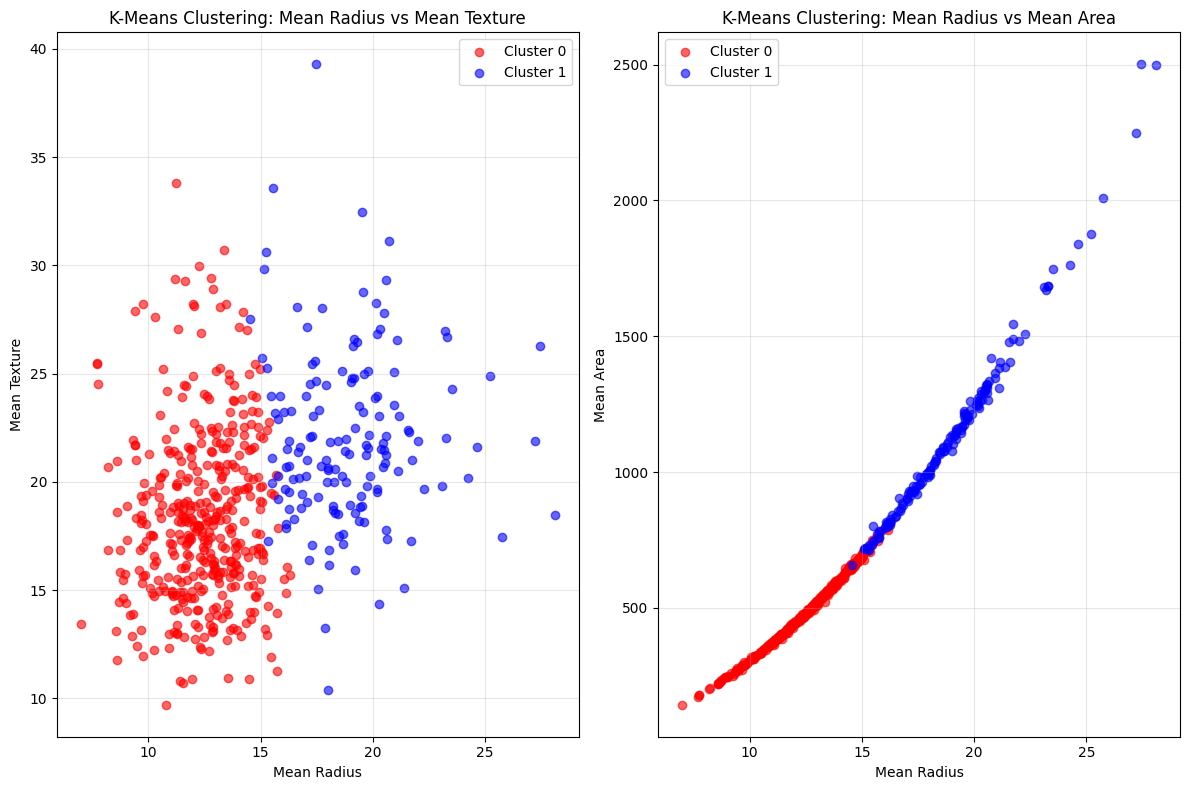

Clusters visualized successfully!
Cluster 0 (Red): 417 samples
Cluster 1 (Blue): 152 samples


In [ ]:
# Convert PySpark DataFrame to Pandas for visualization
plot_data = clustered_data.select('mean_radius', 'mean_texture', 'mean_area', 'prediction').toPandas()

# Create visualization
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 8))

# Plot 1: Mean Radius vs Mean Texture
colors = ['red', 'blue']
for i in [0, 1]:
    cluster_data = plot_data[plot_data['prediction'] == i]
    ax1.scatter(cluster_data['mean_radius'], cluster_data['mean_texture'],
               c=colors[i], label=f'Cluster {i}', alpha=0.6)

ax1.set_xlabel('Mean Radius')
ax1.set_ylabel('Mean Texture')
ax1.set_title('K-Means Clustering: Mean Radius vs Mean Texture')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Plot 2: Mean Radius vs Mean Area
for i in [0, 1]:
    cluster_data = plot_data[plot_data['prediction'] == i]
    ax2.scatter(cluster_data['mean_radius'], cluster_data['mean_area'],
               c=colors[i], label=f'Cluster {i}', alpha=0.6)

ax2.set_xlabel('Mean Radius')
ax2.set_ylabel('Mean Area')
ax2.set_title('K-Means Clustering: Mean Radius vs Mean Area')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("Clusters visualized successfully!")
print(f"Cluster 0 (Red): {len(plot_data[plot_data['prediction'] == 0])} samples")
print(f"Cluster 1 (Blue): {len(plot_data[plot_data['prediction'] == 1])} samples")

## 7. Summary and Clean Up

In [ ]:
print("=== EXPERIMENT SUMMARY ===")
print(f"✓ Successfully clustered {spark_df.count()} breast cancer samples into 2 groups")
print(f"✓ Achieved silhouette score of {silhouette_score:.3f}")
print(f"✓ Visualized clusters graphically using scatter plots")
print("✓ Each cluster represents samples with similar characteristics")
print("\nK-Means clustering helps identify patterns in medical data!")

# Stop Spark
spark.stop()
print("\nExperiment completed successfully!")

=== EXPERIMENT SUMMARY ===
✓ Successfully clustered 569 breast cancer samples into 2 groups
✓ Achieved silhouette score of 0.637
✓ Visualized clusters graphically using scatter plots
✓ Each cluster represents samples with similar characteristics

K-Means clustering helps identify patterns in medical data!

Experiment completed successfully!
